## 1. Učitavanje potrebnih paketa

In [1]:
# Standardne biblioteke
import sys
sys.path.append('../../')

import itertools

# Analiza podataka
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# FinRL i stable_baselines3 za strojno učenje i trgovanje
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_primo_trading.env_primo_default import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from stable_baselines3.common.logger import configure

# Konfiguracijski fajlovi i pomoćne funkcije iz FinRL
from finrl.config import INDICATORS
from finrl.main import check_and_make_directories

# Omogućavanje prikaza grafikona unutar Jupyter bilježnice
%matplotlib inline

TRAINED_MODEL_DIR = 'files/models_NFLX'
RESULTS_DIR = 'files/results_NFLX'
DATA_DIR = 'files/data_NFLX'

# Provjera i kreiranje direktorija
check_and_make_directories([TRAINED_MODEL_DIR, DATA_DIR])

## 2. Dohvaćanje podataka

Imamo klasu nazvanu YahooDownloader koja koristi yfinance za dohvaćanje podataka s Yahoo Finance.

U YahooDownloader-u FinRL-a, modificirali smo okvir podataka u oblik koji je pogodan za daljnju obradu podataka. Koristimo prilagođenu zatvarajuću cijenu umjesto zatvarajuće cijene i dodajemo stupac koji predstavlja dan u tjednu (0-4 što odgovara ponedjeljku-petku).

In [2]:
# Intervali za trening i trgovanje
TRAIN_START_DATE = '2021-09-01'
TRAIN_END_DATE = '2023-12-31'
TRADE_START_DATE = '2024-01-01'
TRADE_END_DATE = '2024-07-31'

In [3]:
# Preuzimamo sve podatke
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                         end_date = TRADE_END_DATE,
                         ticker_list = ['CRM']).fetch_data()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (731, 8)


In [4]:
df_raw.head()

,date,open,high,low,close,volume,tic,day
0,2021-09-01,266.269989,273.260010,265.589996,267.553497,7189000,CRM,2
1,2021-09-02,269.000000,269.260010,263.920013,263.395386,4498300,CRM,3
2,2021-09-03,263.600006,267.410004,261.799988,266.317017,7356700,CRM,4
3,2021-09-07,266.540009,267.899994,264.070007,264.452332,4672500,CRM,1
4,2021-09-08,263.619995,264.339996,261.579987,261.869751,3851500,CRM,2


## 3. Procesiranje podataka

Koristimo definiranu klasu FeatureEngineer pomoću koje radimo procesiranje podataka i dodavanje tehničkih indikatora.

Opcija use_vix uključuje VIX indeks, poznat kao "indeks straha", koji predstavlja očekivanu volatilnost tržišta dionica temeljenu na opcijama S&P 500 indeksa. VIX pomaže modelu da razumije tržišnu nesigurnost, s višim vrijednostima koje ukazuju na veću nesigurnost.

Opcija use_turbulence uključuje indeks turbulencije, koji mjeri neobične tržišne fluktuacije i služi kao pokazatelj rizika i tržišnih šokova. Koristan je za identifikaciju perioda visoke volatilnosti, pomažući modelu da se prilagodi financijskim krizama.

Inače dosta zgodna klasa koja sadrži korisne metode za obradu financijskih podataka i može se primjeniti u brojne druge svrhe.

In [5]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=False,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_raw)

[*********************100%%**********************]  1 of 1 completed

Successfully added technical indicators
Shape of DataFrame:  (730, 8)
Successfully added vix


In [6]:
# Stvara listu jedinstvenih oznaka dionica (tickers) iz stupca 'tic' DataFrame-a 'processed'.
list_ticker = processed["tic"].unique().tolist()

# Stvara listu datuma između najranijeg i najkasnijeg datuma u DataFrame-u 'processed', pretvara ih u stringove.
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))

# Stvara kombinacije svih datuma i oznaka dionica koristeći kartezijev produkt.
combination = list(itertools.product(list_date,list_ticker))

# Stvara novi DataFrame 'processed_full' s kolonama "date" i "tic", koji sadrži sve kombinacije datuma i oznaka dionica.
# Spaja taj DataFrame s originalnim DataFrame-om 'processed' na temelju kolona "date" i "tic", koristeći 'left' spajanje.
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")

# Filtrira 'processed_full' DataFrame da sadrži samo one retke čiji su datumi prisutni u originalnom DataFrame-u 'processed'.
processed_full = processed_full[processed_full['date'].isin(processed['date'])]

# Sortira 'processed_full' DataFrame po datumu i oznaci dionica.
processed_full = processed_full.sort_values(['date','tic'])

# Zamjenjuje sve nedostajuće vrijednosti (NaN) s 0 u DataFrame-u 'processed_full'.
processed_full = processed_full.fillna(0)

In [7]:
processed_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
0,2021-09-01,CRM,266.269989,273.260010,265.589996,267.553497,7189000.0,2.0,0.000000,271.354899,259.593984,0.000000,-66.666667,100.000000,267.553497,267.553497,16.110001
1,2021-09-02,CRM,269.000000,269.260010,263.920013,263.395386,4498300.0,3.0,-0.093291,271.354899,259.593984,0.000000,-66.666667,100.000000,265.474442,265.474442,16.410000
2,2021-09-03,CRM,263.600006,267.410004,261.799988,266.317017,7356700.0,4.0,-0.028272,270.025718,261.484882,42.091521,-57.595424,100.000000,265.755300,265.755300,16.410000
6,2021-09-07,CRM,266.540009,267.899994,264.070007,264.452332,4672500.0,1.0,-0.065330,269.151838,261.707277,32.937883,-40.144232,76.097190,265.429558,265.429558,18.139999
7,2021-09-08,CRM,263.619995,264.339996,261.579987,261.869751,3851500.0,2.0,-0.186859,269.248524,260.186668,25.113117,-147.494836,85.320268,264.717596,264.717596,17.959999


In [8]:
# Pripremamo trening i trade set sukladno definiranim datumima
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

586
144


In [9]:
# Spremamo podatke
train.to_csv(DATA_DIR + '/train_data.csv')
trade.to_csv(DATA_DIR + '/trade_data.csv')

## 4. Priprema environmenta

stock_dimension predstavlja broj jedinstvenih dionica u skupu podataka. Ova vrijednost se koristi za određivanje koliko različitih dionica model može trgovati.

state_space označava ukupnu veličinu prostora stanja koji model koristi za donošenje odluka. Prostor stanja uključuje trenutne podatke o dionicama (kao što su cijene i tehnički indikatori) i informacije o trenutnom portfelju (kao što su broj dionica koje posjeduje). Veličina prostora stanja određena je formulom koja uzima u obzir broj dionica i broj tehničkih indikatora.

In [10]:
# Izračunavamo dimenziju (broj jedinstvenih dionica) iz DataFrame-a 'train'.
stock_dimension = len(train.tic.unique())

# Izračunavamo veličinu stanja na temelju dimenzije i broja tehničkih indikatora.
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [11]:
# Stvara liste troškova kupnje i prodaje za svaku dionicu.
buy_cost_list = sell_cost_list = [0] * stock_dimension

# Inicijalizira broj dionica za svaku dionicu na 0.
num_stock_shares = [0] * stock_dimension

e_train_gym je instanca klase StockTradingEnv, koja predstavlja okruženje za trgovanje. Ovo okruženje koristi podatke i parametre definirane za simulaciju tržišta dionica. Model uči kako trgovati unutar ovog okruženja, pokušavajući maksimizirati ukupnu nagradu (profit) kroz seriju trgovačkih odluka.

env_train dobiva se pozivom metode get_sb_env() na instanci e_train_gym. Ova metoda vraća okruženje kompatibilno s bibliotekom Stable Baselines 3, koja se koristi za implementaciju algoritama pojačanog učenja. Drugi povratni element, koji se ovdje ignorira (_), može se koristiti za dodatne informacije ili funkcionalnosti koje pruža okruženje.

In [12]:
# Definira argumente za okruženje trgovanja.
env_kwargs = {
    "hmax": 1000,  # Maksimalni broj dionica koje se mogu kupiti ili prodati u jednoj transakciji.
    "initial_amount": 100000,  # Početni iznos kapitala.
    "num_stock_shares": num_stock_shares,  # Početni broj dionica svake dionice u portfelju, inicijalno postavljen na 0.
    "buy_cost_pct": buy_cost_list,  # Postotci troškova za kupnju i prodaju dionica, odnosno, koji simuliraju stvarne troškove transakcija.
    "sell_cost_pct": sell_cost_list,  # Postotci troškova za kupnju i prodaju dionica, odnosno, koji simuliraju stvarne troškove transakcija.
    "state_space": state_space,  # Prije definirane veličine koje utječu na strukturu okruženja.
    "stock_dim": stock_dimension,  # Prije definirane veličine koje utječu na strukturu okruženja.
    "tech_indicator_list": INDICATORS,  # Lista tehničkih indikatora koji će se koristiti za analizu stanja tržišta.
    "action_space": stock_dimension,  # Veličina prostora akcija, odnosno, broj različitih akcija koje model može izvršiti.
    "reward_scaling": 1e-4  # Faktor skaliranja za nagradu, koristi se za prilagodbu veličine nagrade kako bi se olakšalo učenje.
}

# Kreira okruženje za treniranje.
e_train_gym = StockTradingEnv(df = train, **env_kwargs)

# Dohvaća okruženje pogodno za Stable Baselines i neiskorišteni objekt.
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


## 5. Trening DRL agenata

Ovdje su algoritmi dubokog pojačanog učenja (DRL) iz biblioteke Stable Baselines 3. Radi se o biblioteci koja je implementirala popularne DRL algoritme koristeći PyTorch.

Kao zamjena mogu se koristiti biblioteke ElegantRL i Ray RLlib.

### Trening 5 različitih DRL agenata (A2C, DDPG, PPO, TD3, SAC)

In [13]:
# Postavljanje odgovarajućih vrijednosti na 'True' za algoritme koje želite koristiti
if_using_a2c = False
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = False

#### Agent 1: A2C

In [14]:
# Ponovno se kreira instanca DRL agenta s predanim okruženjem (nije potrebno ponovno raditi, ali zbog lakših uputa neka stoji)
agent = DRLAgent(env = env_train)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.01, "learning_rate": 0.00025}
model_a2c = agent.get_model("a2c", model_kwargs = A2C_PARAMS)

if if_using_a2c:
  # Postavljanje loggera za praćenje i zapisivanje informacija tijekom treniranja
  tmp_path = RESULTS_DIR + '/a2c'
  # Konfigurira novi logger koji će ispisivati informacije na standardni izlaz, zapisivati u CSV datoteku i TensorBoard
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Postavlja novi logger za model A2C.
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.00025}
Using cpu device


In [15]:
# Trenira model A2C s definiranim ukupnim brojem vremenskih koraka, samo ako je if_using_a2c postavljen na True.
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000) if if_using_a2c else None

In [16]:
# Sprema trenirani model A2C u definirani direktorij, samo ako je if_using_a2c postavljen na True.
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

#### Agent 2: DDPG

In [17]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.00025}
model_ddpg = agent.get_model("ddpg", model_kwargs = DDPG_PARAMS)

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.00025}
Using cpu device


In [18]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

In [19]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

#### Agent 3: PPO

In [20]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
       "n_steps": 2048,
       "ent_coef": 0.01,
       "learning_rate": 0.00025,
       "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to files/results_NFLX/ppo


In [21]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=400000) if if_using_ppo else None

------------------------------------
| time/              |             |
|    fps             | 3275        |
|    iterations      | 1           |
|    time_elapsed    | 0           |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -0.26188937 |
------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2996         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0060328003 |
|    clip_fraction        | 0.0417       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.32        |
|    learning_rate        | 0.00025      |
|    loss                 | 0.0635       |
|    n_updates            | 10           |
|    policy_gradient_l

In [22]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

#### Agent 4: TD3

In [23]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [24]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

In [25]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

#### Agent 5: SAC

In [26]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.00025,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.00025, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [27]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000) if if_using_sac else None

In [28]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## 6. Priprema za backtest

In [29]:
# Po potrebi učitavamo sporemnjene podatke ako smo restrartali proces (nije potrebno)
train = pd.read_csv(DATA_DIR + '/train_data.csv')
trade = pd.read_csv(DATA_DIR + '/trade_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [30]:
# Po potrebi učitavamo sporemnjene podatke o treningu agenata ako smo restrartali proces (nije potrebno)
if_using_a2c = False
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = False

trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## 7. Trgovanje (podatci izvan trening seta)

Ovdje sada za trgovanje koristimo trade skup podataka koji nikad nije bio korišten za trening. Dodatno sličnim pristupom bi mogli i dotrenirati postojeći spremljeni model.

Brojni hiperparametri, na primjer, stopa učenja, ukupan broj uzoraka za trening – utječu na proces učenja i obično se određuju testiranjem nekih varijacija.

In [31]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [32]:
buy_cost_list = sell_cost_list = [0] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 1000,
    "initial_amount": 100000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

Ovaj dio se odnosi se na korištenje dubokog pojačanog učenja (DRL) za simulaciju trgovanja u stvarnom vremenu koristeći prethodno trenirani model (u ovom slučaju, A2C). StockTradingEnv je okruženje koje simulira tržište dionica s obzirom na povijesne podatke, prag turbulencije (koji se koristi za određivanje volatilnosti tržišta), i 'VIX' kao pokazatelj rizika. Nakon inicijalizacije okruženja, koristi se metoda get_sb_env() za dohvaćanje okruženja i početne opservacije koje su kompatibilne sa Stable Baselines bibliotekom.

In [33]:
# Inicijalizacija okruženja za trgovanje s definiranim DataFrame-om 'trade', pragom turbulencije i pokazateljem rizika 'vix',
# zajedno s ostalim parametrima okruženja ('env_kwargs').
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

# Dohvaćanje okruženja kompatibilnog sa Stable Baselines i početne opservacije.
env_trade, obs_trade = e_trade_gym.get_sb_env()

Zatim se DRL agent koristi za predviđanje akcija trgovanja i promjene u vrijednosti računa na temelju treniranog modela. To omogućuje evaluaciju performansi modela u scenariju izvan uzorka, pružajući uvid u to kako bi model mogao performirati u stvarnim trgovačkim uvjetima. Ako je odabrana upotreba A2C algoritma (kao što je indicirano varijablom if_using_a2c), provodi se predviđanje; u suprotnom, rezultat se postavlja na None.

In [34]:
# Korištenje DRL agenta za predviđanje koristeći trenirani model 'trained_a2c' i definirano okruženje trgovanja 'e_trade_gym'.
# Rezultati su dva DataFrame-a: 'df_account_value_a2c' s vrijednostima računa i 'df_actions_a2c' s akcijama koje su poduzete,
# ako je 'if_using_a2c' postavljen na True; inače se vraća (None, None).
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)

In [35]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)

In [36]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)

hit end!


In [37]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else (None, None)

In [38]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)

## 8. B&H za usporedbu

In [39]:
df_aapl = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['CRM']).fetch_data()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (145, 8)


In [40]:
df_aapl = df_aapl[['date','close']]
fst_day = df_aapl['close'].iloc[0]
buy_and_hold = pd.merge(df_aapl['date'], df_aapl['close'].div(fst_day).mul(100000), 
                        how='outer', left_index=True, right_index=True).set_index('date')

## 10. Provodima backetinskg modela

In [41]:
# Postavljanje indeksa DataFrame-ova vrijednosti računa za svaku od DRL strategija, ako su odabrane.
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None

# Kreiranje praznog DataFrame-a za rezultate.
result = pd.DataFrame()

# Spajanje rezultata svih DRL strategija u jedan DataFrame, ako su odabrane.
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))

# Spajanje rezultata optimizacije srednje varijance i indeksa DJIA s glavnim rezultatima.
result = pd.merge(result, buy_and_hold, how='outer', left_index=True, right_index=True)

In [42]:
# Dodavanje imena stupaca na temelju odabranih strategija.
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None
col_name.append('B&H')
result.columns = col_name

In [43]:
# Prikazivanje rezultata
result.head()

,PPO,B&H
date,,
2024-01-02,100000.000000,100000.000000
2024-01-03,98327.397507,98325.065015
2024-01-04,98327.397507,98090.810588
2024-01-05,98280.491013,98043.958507
2024-01-08,98280.491013,101850.615350


### Ovdje plotiramo graf koji pokazuje ukupnu vrijednost portfolija korz vrijeme za pojedinu strategiju i benchmark

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

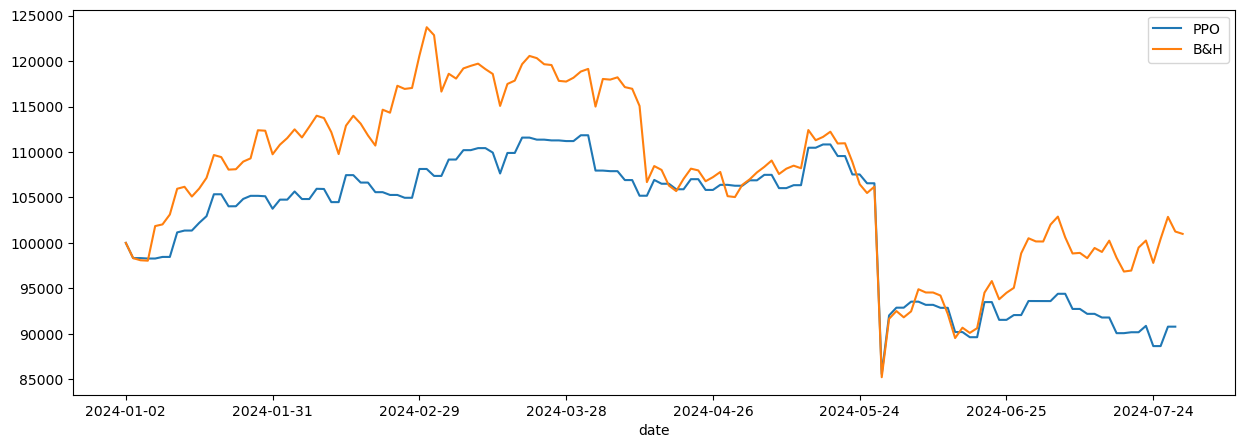

In [44]:
# Postavljanje veličine figure za grafikone i crtanje grafikona performansi strategija trgovanja.
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

Na temelju vrijednosti portfolija računamo dnevne povrate 

In [45]:
from pyfolio import timeseries
import pandas as pd

# Lista strategija za koje želite generirati statistike
strategies = ['A2C', 'DDPG', 'PPO', 'TD3', 'SAC', "B&H"]

for strategy in strategies:
    column_name = f'{strategy}'
    if column_name in result.columns:
        # Izračunavanje dnevnih povrata iz vrijednosti portfelja
        result[f'{strategy}_returns'] = result[column_name].pct_change()

/opt/anaconda3/lib/python3.11/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(
/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_23081/728507394.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  result[f'{strategy}_returns'] = result[column_name].pct_change()


In [46]:
result.head()

,PPO,B&H,PPO_returns,B&H_returns
date,,,,
2024-01-02,100000.000000,100000.000000,NaN,NaN
2024-01-03,98327.397507,98325.065015,-0.016726,-0.016749
2024-01-04,98327.397507,98090.810588,0.000000,-0.002382
2024-01-05,98280.491013,98043.958507,-0.000477,-0.000478
2024-01-08,98280.491013,101850.615350,0.000000,0.038826


### Računamo povrate po odabranoj strategiji

In [47]:
# Pretpostavljamo da result DataFrame već sadrži vrijednosti portfelja za svaku strategiju
for strategy in strategies:
    # Provjerite postoji li strategija u DataFrame-u
    if f'{strategy}_returns' in result.columns:
        # Izvlačenje dnevnih povrata za trenutnu strategiju
        returns = result[f'{strategy}_returns'].dropna()
        returns.index = pd.to_datetime(returns.index)

        # Izračunavanje statistika performansi za trenutnu strategiju
        perf_stats = timeseries.perf_stats(returns=returns, factor_returns=None, positions=None, transactions=None, turnover_denom="AGB")

        # Ispis statistika performansi
        print(f"==============Strategy Stats ({strategy})==============")
        print(perf_stats)
        print("\n")
    else:
        print(f"Strategija {strategy} nije pronađena u rezultatima.\n")


Strategija A2C nije pronađena u rezultatima.

Strategija DDPG nije pronađena u rezultatima.

==============Strategy Stats (PPO)==============
Annual return          -0.155593
Cumulative returns     -0.092118
Annual volatility       0.326940
Sharpe ratio           -0.339797
Calmar ratio           -0.662570
Stability               0.373829
Max drawdown           -0.234833
Omega ratio             0.892404
Sortino ratio          -0.394072
Skew                   -5.621522
Kurtosis               57.110317
Tail ratio              1.254865
Daily value at risk    -0.041631
dtype: float64


Strategija TD3 nije pronađena u rezultatima.

Strategija SAC nije pronađena u rezultatima.

==============Strategy Stats (B&H)==============
Annual return           0.017412
Cumulative returns      0.009913
Annual volatility       0.386981
Sharpe ratio            0.250135
Calmar ratio            0.055966
Stability               0.328070
Max drawdown           -0.311112
Omega ratio             1.056476
Sortino

### Plotiramo komulativne povrate za pojedinu strategiju

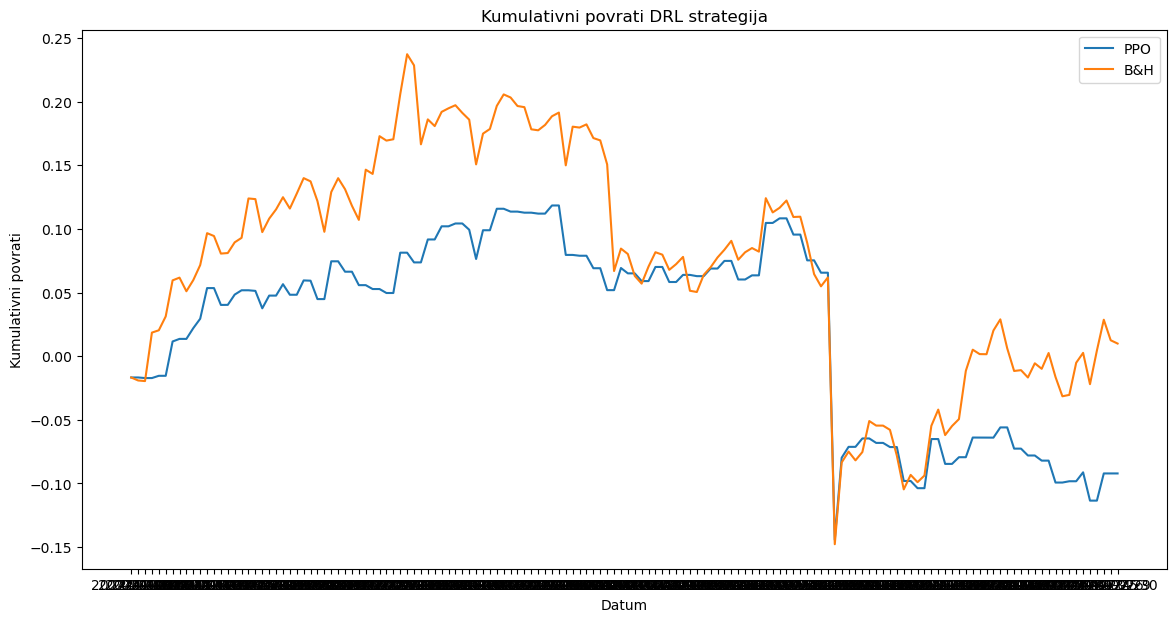

In [48]:
import matplotlib.pyplot as plt

# Postavljanje veličine figure za grafikon
plt.figure(figsize=(14, 7))

# Prolazak kroz svaku strategiju i crtanje njenih kumulativnih povrata
for strategy in strategies:
    if f'{strategy}_returns' in result.columns:
        # Izvlačenje dnevnih povrata za trenutnu strategiju i pretvaranje u decimalni format ako je potrebno
        returns = result[f'{strategy}_returns'].dropna() + 1  # Dodaje 1 za korištenje cumprod()

        # Izračunavanje kumulativnih povrata
        cumulative_returns = returns.cumprod() - 1  # Oduzima 1 na kraju za prikazivanje pravog kumulativnog povrata

        # Plotiranje kumulativnih povrata
        plt.plot(cumulative_returns.index, cumulative_returns, label=strategy)

# Dodavanje naslova i legende na grafikon
plt.title('Kumulativni povrati DRL strategija')
plt.legend()

# Postavljanje oznaka za x i y osi
plt.xlabel('Datum')
plt.ylabel('Kumulativni povrati')

# Prikazivanje grafikona
plt.show()


### Spremamo rezultate u CSV
Potrebno promjeniti za svakog agenta

In [50]:
import pickle

# Za df_account_value_sac
with open('results/6. CRM/crm_finrl_df_account_value_ppo.pkl', 'wb') as f:
    pickle.dump(df_account_value_ppo, f)

# Za df_actions_sac
with open('results/6. CRM/crm_finrl_df_actions_ppo.pkl', 'wb') as f:
    pickle.dump(df_actions_ppo, f)

# Za buy_and_hold
with open('results/6. CRM/crm_finrl_buy_and_hold.pkl', 'wb') as f:
    pickle.dump(buy_and_hold, f)